## 1. Imports y lectura de datos

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

from utils.mlp_regression import EmbeddingDataset, train_mlp_regressor
from utils.vis import plot_1d_predictions, mae_por_class
from utils.roberta_regression import predict_batch_values, load_lora_regression_model, political_score_batch

np.set_printoptions(suppress=True)

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [3]:
tweets = pd.read_parquet("../data/embeddings/tweets-embeddings.parquet")

## 2. Entrenamiento sobre ```political-leaning-tweets```

In [4]:
label_map = {"L": -1, "C": 0, "R": 1}
tweets["label"] = tweets["label"].map(label_map)

train_tweets, test_tweets = train_test_split(tweets, test_size=0.2, stratify=tweets["label"], random_state=42, shuffle=True)
X_train_emb = np.vstack(train_tweets["embedding"].values)
X_test_emb  = np.vstack(test_tweets["embedding"].values)
y_train = train_tweets["label"].values
y_test  = test_tweets["label"].values

X_train_text = train_tweets["text"].values
X_test_text  = test_tweets["text"].values

#### a. Google Embeddings + $L_2$ Regression

In [5]:
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train_emb, y_train)

y_pred_reg = ridge_model.predict(X_test_emb)
mae = mean_absolute_error(y_test, y_pred_reg)
r2 = r2_score(y_test, y_pred_reg)

print("\n=== Testing de Regresión con regularización en Political Tweets ===")
print(f'Train samples: {X_train_emb.shape[0]}, Test samples: {X_test_emb.shape[0]}\n')

print("MAE:", mae)
print("R^2:", r2, "\n")

mae_per_class = mae_por_class(y_test, y_pred_reg)
for cls, mae_cls in mae_per_class.items():
    print(f"MAE for class {cls}: {mae_cls}")


=== Testing de Regresión con regularización en Political Tweets ===
Train samples: 7024, Test samples: 1757

MAE: 0.5029268787785369
R^2: 0.38108744135824457 

MAE for class L: 0.650361860908343
MAE for class C: 0.2778591179679484
MAE for class R: 0.5808112529919643


#### b. Google Embeddings + MLP

In [6]:
train_ds = EmbeddingDataset(X_train_emb, y_train)
test_ds  = EmbeddingDataset(X_test_emb, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1), 
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

In [7]:
input_dim = X_train_emb.shape[1]

mlp_model, history = train_mlp_regressor(
    X_train=X_train_emb, y_train=y_train,
    X_test=X_test_emb, y_test=y_test,
    MLP=MLP, dataset_cls=EmbeddingDataset,
    input_dim=input_dim, device=device,
    batch_size=32, lr=1e-3, epochs=100,
    eval_every=10,
)

Epoch 10/100  |  Train Loss: 0.2001
              |  Test MAE: 0.4279  |  Test R^2: 0.4173
Epoch 20/100  |  Train Loss: 0.0803
              |  Test MAE: 0.4390  |  Test R^2: 0.3579
Epoch 30/100  |  Train Loss: 0.0558
              |  Test MAE: 0.4297  |  Test R^2: 0.3756
Epoch 40/100  |  Train Loss: 0.0457
              |  Test MAE: 0.4194  |  Test R^2: 0.3839
Epoch 50/100  |  Train Loss: 0.0412
              |  Test MAE: 0.4170  |  Test R^2: 0.3736
Epoch 60/100  |  Train Loss: 0.0356
              |  Test MAE: 0.4134  |  Test R^2: 0.3666
Epoch 70/100  |  Train Loss: 0.0339
              |  Test MAE: 0.4150  |  Test R^2: 0.3646
Epoch 80/100  |  Train Loss: 0.0330
              |  Test MAE: 0.4145  |  Test R^2: 0.3544
Epoch 90/100  |  Train Loss: 0.0282
              |  Test MAE: 0.4100  |  Test R^2: 0.3553
Epoch 100/100  |  Train Loss: 0.0282
               |  Test MAE: 0.4042  |  Test R^2: 0.3691


In [8]:
mlp_model.eval();
y_pred_mlp = []
with torch.no_grad():
    for batch in test_loader:
        inputs, _ = batch
        inputs = inputs.to(device).float()
        outputs = mlp_model(inputs)
        y_pred_mlp.extend(outputs.cpu().numpy())

In [9]:
mae_per_class = mae_por_class(y_test, y_pred_mlp)

print("\n=== Testing de MLP en Political Tweets ===")
print("MAE:", history['test_mae'][-1])
print("R^2:", history['test_r2'][-1], "\n")

for cls, mae_cls in mae_per_class.items():
    print(f"MAE for class {cls}: {mae_cls}")


=== Testing de MLP en Political Tweets ===
MAE: 0.4042028784751892
R^2: 0.3691239356994629 

MAE for class L: 0.5197406325027601
MAE for class C: 0.2118133149227388
MAE for class R: 0.4812519563228502


### c. BERT based model

In [10]:
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-cased")
bert_model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")
bert_model.eval();

In [11]:
y_pred_bert, y_probs = political_score_batch(X_test_text, bert_model=bert_model, tokenizer_bert=tokenizer_bert, batch_size=32, device=device)
mae_bert = mean_absolute_error(y_test, y_pred_bert)
r2_bert = r2_score(y_test, y_pred_bert)
mae_class_bert = mae_por_class(y_test, y_pred_bert)

print("\n=== Pretrained BERT (HF) en Political Tweets ===")
print(f"MAE global: {mae_bert:.4f}")
print(f"R^2 global: {r2_bert:.4f}\n")
for cls, mae_cls in mae_class_bert.items():
    print(f"MAE for class {cls}: {mae_cls}")

Computing political scores: 100%|██████████| 55/55 [00:03<00:00, 15.49it/s]



=== Pretrained BERT (HF) en Political Tweets ===
MAE global: 0.7234
R^2 global: -0.0891

MAE for class L: 1.0029282634598242
MAE for class C: 0.20627873216051634
MAE for class R: 0.9613568773453438


### d. RoBERTa Fine-Tuned por nosotros

In [ ]:
#####################
### Entrenamiento ###
#####################

# from utils.roberta_regression import (prepare_dataset, load_roberta_lora_regression, tokenize_dataset,
#                                       train_roberta_lora_regression, save_lora_model)

# dataset = prepare_dataset(train_tweets, text_col="text", label_col="label")
# tokenizer, model = load_roberta_lora_regression("roberta-base")
# dataset_tok = tokenize_dataset(dataset, tokenizer)
# trainer = train_roberta_lora_regression(
#     model, tokenizer, dataset_tok,
#     output_dir="roberta_lora_regression", num_epochs=10,
# )

# save_lora_model(trainer, tokenizer, "saved_roberta_regression")

In [14]:
tokenizer_roberta, model_roberta = load_lora_regression_model(
    "roberta-base", "saved_roberta_regression"
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
y_pred_roberta = predict_batch_values(texts=X_test_text, tokenizer=tokenizer_roberta, model=model_roberta, device=device, batch_size=128)
mae_roberta = mean_absolute_error(y_test, y_pred_roberta)
r2_roberta = r2_score(y_test, y_pred_roberta)
mae_class_roberta = mae_por_class(y_test, y_pred_roberta)

print("\n=== Pretrained RoBERTa Fine-Tuned en Political Tweets ===")
print(f"MAE global: {mae_roberta:.4f}")
print(f"R^2 global: {r2_roberta:.4f}\n")
for cls, mae_cls in mae_class_roberta.items():
    print(f"MAE for class {cls}: {mae_cls}")

Predicting: 100%|██████████| 14/14 [00:03<00:00,  3.89it/s]


=== Pretrained RoBERTa Fine-Tuned en Political Tweets ===
MAE global: 0.4484
R^2 global: 0.3732

MAE for class L: 0.564404892278278
MAE for class C: 0.23307570928084717
MAE for class R: 0.5477741762992542


## 3. comparación entre modelos

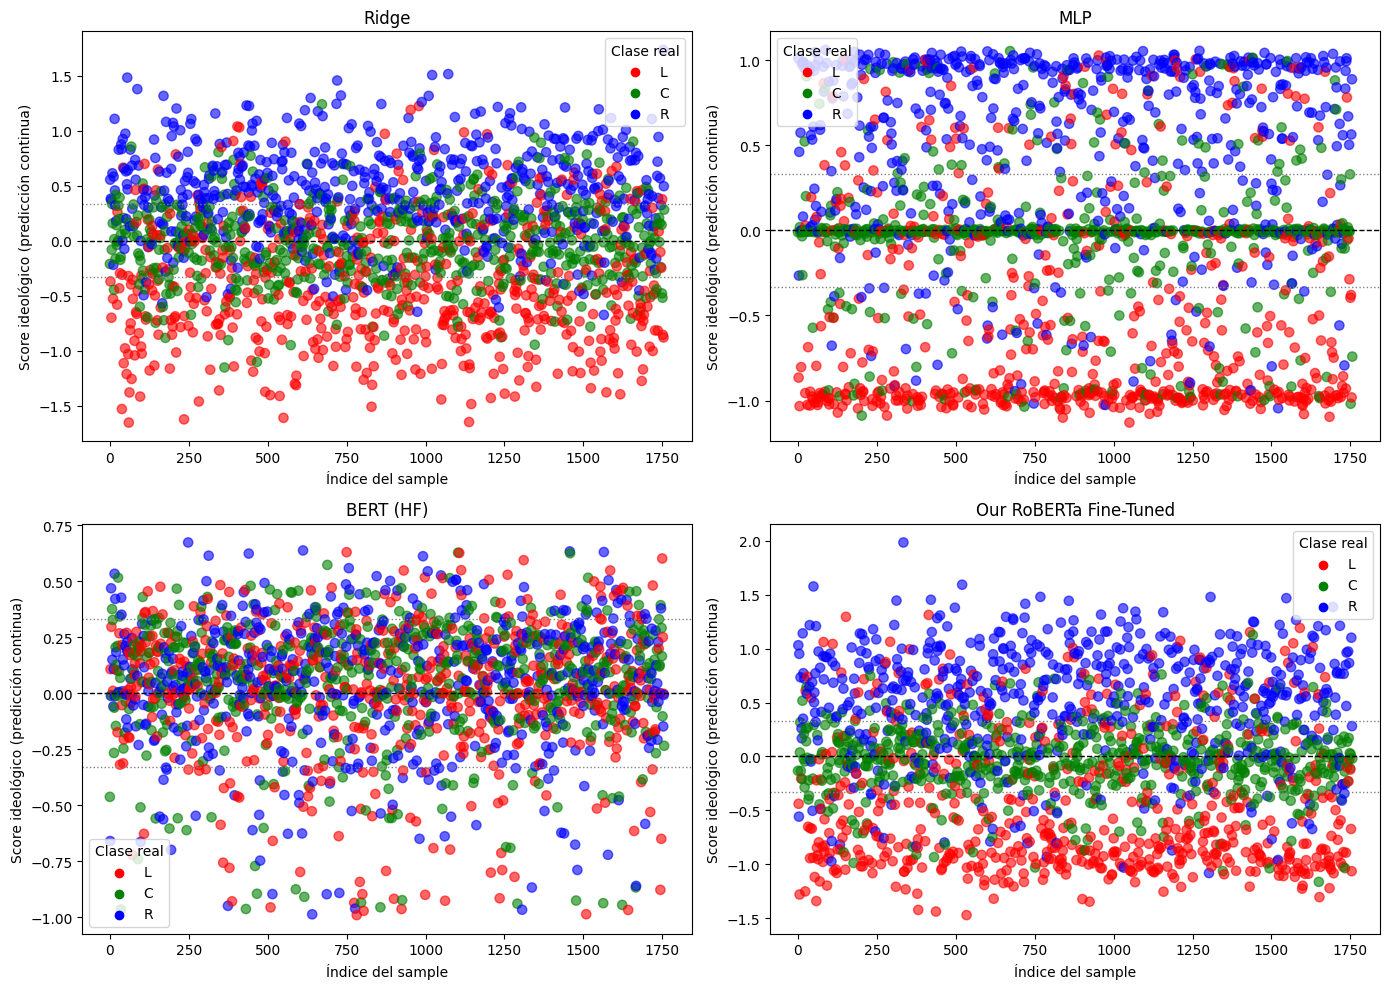

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
axes = ax.flatten()

plot_1d_predictions(y_pred=y_pred_reg, true_labels=y_test, ax=axes[0], title="Ridge")
plot_1d_predictions(y_pred=y_pred_mlp, true_labels=y_test, ax=axes[1], title="MLP")
plot_1d_predictions(y_pred=y_pred_bert, true_labels=y_test, ax=axes[2], title="BERT (HF)")
plot_1d_predictions(y_pred=y_pred_roberta, true_labels=y_test, ax=axes[3], title="Our RoBERTa Fine-Tuned")
plt.tight_layout()